# Assignment 2, Question 1: Self-tuning robots

Instructions:
* Please complete the assignments in this notebook. You should submit this notebook, as well as a PDF version, to blackboard.
* To create the PDF, see File > Download as. You can export to PDF via Latex, or export to HTML and then print to PDF.
* Check your code before submission. It should be possible to reproduce all your results via 'run all'.
* Add a clear explanation of your approach and an in-depth interpretation of your results for every subquestion. Use markdown cells for this.
* Keep the PDF for each question below 10 pages. Remove these instructions in the final PDF.
* Avoid all unnecessary outputs. Only output the answers to the questions. Add ';' behind lines that generate output to suppress the output.
* Add the names of all team members below.

TEAM MEMBER 1 = ...  
TEAM MEMBER 2 = ...  
TEAM MEMBER 3 = ...  
TEAM MEMBER 4 = ...  

(Add a short description of what each team member contributed)

In [3]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures

## Robot Navigation
The [Wall robot navigation](https://www.openml.org/d/1497) contains training data for a robot equiped with ultrasound sensors. Based on 24 sensor readings, the robot has to figure out how to move though an office space without hitting walls or other obstacles. In this assignment, the robot uses an SVM to learn how to do this. 

However, instead of building a static model, we want to robot to tune the hyperparameters of its SVM model regularly. This will make it more robust to changes, for instance a breaking sensor. Since the robot is very busy, this regular re-training should take as little time as possible. Your assignment is to implement a fast tuning algorithm that optimizes the hyperparameter configurations faster and better than a random search or grid search.

## The data
The data is visualized below. It contains traces of training runs of the robot. In the figure below, we plot the first two sensor readings, color-coded by the correct action to take (move forward, left or right). You can handle these data points as independently sampled, i.e. you never need to look at the 'previous' data point.

In [56]:
# Download Wall Robot Navigation data from OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, attribute_names = robot.get_data(target=robot.default_target_attribute, return_attribute_names=True);
labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

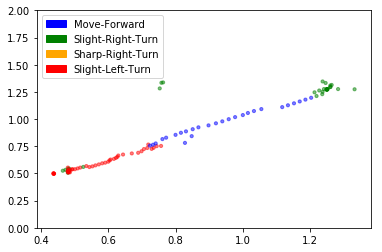

In [77]:
import matplotlib.patches as mpatches
from matplotlib import colors

cmap = colors.ListedColormap(['blue', 'green', 'orange', 'red'])
legend_handles = list()
for i in range(4):
    legend_handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
plt.legend(handles=legend_handles, loc='upper left')

n = 120 # First 120 points
plt.scatter(X[:,0][0:n], X[:,1][0:n], c=y[0:n], cmap=cmap, alpha=0.5, s=10)
plt.ylim(0,2);

## Multi-fidelity optimization
We will implement a fast optimization technique generally known as _multi-fidelity optimization_. Instead of training the model on all the training data for every hyperparameter configuration, we use the following procedure:

Successive Halving (only look at the top left image):
- collect $n$ random hyperparameter configurations (squares in the image below)
- split the original training data randomly in half, and repeat this $k$ times
- evaluate all hyperparameter configurations on the smallest sample
- select the best 50% of configurations (green squares), and run these on the next larger sample
- repeat until all training data has been used, and return the best of the remaining configuration (white squares)

Obviously, this can lead to suboptimal results, since you may remove a configuration too soon: it may be worse on a small sample but better on a larger sample, i.e. its learning curve may cross and overtake others. A simple solution for this is called [_Hyperband_](https://arxiv.org/pdf/1603.06560.pdf), illustrated below.

Hyperband:
- Do one successive halving run (also called a _bracket_)
- Start a new bracket with an initial sample twice as large, but with only log_3(n) configurations.
- Repeat until you have done this for all subsamples. Return the best overall method.

![Hyperband](hyperband.png)

In [79]:
# Helper code
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values
    
    values: flattened array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Questions

1_ Landscape analysis: visualize the configuration search space (2 points)

- Do a grid search for an SVM with the RBF kernel. Vary both the C and $\gamma$ at the same time, on a log scale from $2^{-15}$ to $2^{15}$. Use at least 20 values for each, unless you are limited by computational resources.
    - Hint: Start with a small grid and see how long that takes. If this is fast, you can use a finer grid.
- Visualize the results in a plot $C \times \gamma \rightarrow \rho$ with $\rho$ being the performance of the model (Accuracy) visualized as the color of the data point. 
    - You can use the code above for this.
- Interpret and explain the result. Is there a single optimum? Is the landscape smooth? Does this make sense given what you know about SVMs and the role of the $C$ and $\gamma$ parameter?

2_ Implement Successive Halving (3 points)
* Implementing a function that performs a single step as described above
    - Input: data sample, list of input configurations
    - Output: list of selected configurations
    - Print a trace of the best configuration and its accuracy after every step
* Implement the outer loop
    - Input: the complete dataset and list of random configurations
    - Output: the best final configuration and model
* Run the whole procedure using $n=100$ and $k=5$
* Discuss the results. Is this faster/better than a normal grid or random search? Do you still get an improvement in the later runs?

3_ Visualize Successive Halving (2 points)
* For each step, generate a plot with the following:
    - The heatmap as produced in point 1. This requires a complete grid search on the subsample of the data in that step.
    - The selected random configurations superimposed (eg. use white dots/crosses)
* The answer should be a series of 5 of such plots
* Interpret and explain the result. Does it seem like the method is doing anything useful?

4_ Implement Hyperband (3 points)
* Use your previous implementation of successive halving to implement the hyperband method
    * Input: complete dataset and list of random configurations
    * Output: the best configuration and model
    * Print a trace of the best configuration after every bracket (in addition to the trace printed by the successive halving function)
* Discuss the results. Is this faster/better than successive halving? Do you still get an improvement in the later runs?
* Provide a critical discussion on when this method is useful and when it is not.